This is a test notebook for the Gaussian Diffusion peptide project. To test if the model is working, I will give it a synthetic dataset (a sin wave) and check if the diffusion model can diffuse into that:

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn
import time

from guided_diffusion.guided_diffusion_1d import Unet1D, GaussianDiffusion1D
device = "cuda" if torch.cuda.is_available() else "cpu"

In [110]:
class SyntheticDataset(Dataset):
    def __init__(self, num_samples = 1000, seq_length = 64):
        self.latents = []
        self.freqs = []
        for _ in range(num_samples):
            # random sin wave
            freq = np.random.uniform(0.1, 2.0)
            phase = np.random.uniform(0, 2 * np.pi)
            t = np.linspace(0, 10, seq_length)
            latent = ((np.sin(freq * t + phase) / 2) + 0.5).reshape(-1, seq_length)

            self.freqs.append(freq)
            self.latents.append(torch.tensor(latent, dtype=torch.float32))

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        return self.latents[idx]            
    
    def get_latents(self):
        return self.latents
    
        
    def get_freq(self, idx):
        return self.freqs[idx]

In [111]:
def plot_latent(x):
    z = x.reshape(-1)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.linspace(0, 1, 64), z, 'b-', linewidth=2)


In [112]:
def sample(model, num_samples=4):
    model.eval()
    with torch.no_grad():
        samples = model.sample(batch_size=num_samples)
        b, c, n = samples.shape
        
        # Plot the first channel of each sample
        plt.figure(figsize=(12, 8))
        for i in range(num_samples):
            plt.subplot(num_samples, 1, i+1)
            plt.plot(np.linspace(0, 1, n), samples[i, 0].cpu().numpy())
            plt.title(f"Sample {i+1}")
            plt.ylim(0, 1.1)
        plt.tight_layout()
        
        return samples
    

In [113]:
def train(model, dataset, batch_size=16, epochs=10, lr=1e-4):
    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()
        
        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device)
            
            optimizer.zero_grad()
            loss = model(batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}")
        
        avg_loss = epoch_loss / len(dataloader)
        elapsed = time.time() - start_time
        print(f"Epoch {epoch} completed. Avg Loss: {avg_loss:.6f}, Time: {elapsed:.2f}s")

        samples = sample(model)


In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, channels=1, seq_length=64):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (seq_length // 4), 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classifier (high/low frequency)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)

def train_classifier(dataset, seq_length=64, channels=1, batch_size=16, epochs=10):
    # Create labels: higher frequency = 1, lower frequency = 0
    # For simplicity, we'll use FFT to estimate frequency content
    labels = []
    for idx in range(len(dataset)):
        # fft = torch.abs(torch.fft.rfft(signal, dim=1))
        # high_freq_energy = torch.sum(fft[:, seq_length//4:], dim=1)
        # low_freq_energy = torch.sum(fft[:, :seq_length//4], dim=1)
        # label = 1.0 if high_freq_energy.mean() > low_freq_energy.mean() else 0.0
        label = 0.0 if dataset.get_freq(idx) <= 1.0 else 1.0
        labels.append(torch.tensor(label))
    
    # Create dataloader
    from torch.utils.data import DataLoader, TensorDataset
    dataset = TensorDataset(torch.stack(dataset.get_latents()), torch.tensor(labels))  # Changed to stack scalars
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Create classifier
    classifier = SimpleClassifier(channels=channels, seq_length=seq_length)
    
    # Create optimizer
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    
    # Train the classifier
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    classifier.to(device)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x, y = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = classifier(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Classifier Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.6f}")
    
    return classifier

dataset = SyntheticDataset(num_samples=1000, seq_length=64)
classifier = train_classifier(dataset, seq_length=64, channels=1 )

    


Classifier Epoch 1/10, Loss: 0.684301
Classifier Epoch 2/10, Loss: 0.666311
Classifier Epoch 3/10, Loss: 0.631016
Classifier Epoch 4/10, Loss: 0.568656
Classifier Epoch 5/10, Loss: 0.466759
Classifier Epoch 6/10, Loss: 0.343373
Classifier Epoch 7/10, Loss: 0.237388
Classifier Epoch 8/10, Loss: 0.165103
Classifier Epoch 9/10, Loss: 0.123756
Classifier Epoch 10/10, Loss: 0.096738


In [167]:
dataset = SyntheticDataset(num_samples=1000, seq_length=64)

succ = 0
classifier.eval()
for i in range(1000):
    prob = torch.sigmoid(classifier(dataset[i].reshape(-1, 1, 64)))

    if (prob[0].item() >= 0.5) == (dataset.get_freq(i) >= 1.0):
        succ += 1

Using device: cpu


sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 117.36it/s]


Epoch 0, Batch 0, Loss: 0.461913
Epoch 0, Batch 10, Loss: 0.187370
Epoch 0, Batch 20, Loss: 0.267190
Epoch 0, Batch 30, Loss: 0.206875
Epoch 0, Batch 40, Loss: 0.210231
Epoch 0, Batch 50, Loss: 0.091787
Epoch 0, Batch 60, Loss: 0.118977
Epoch 0 completed. Avg Loss: 0.199028, Time: 22.14s


sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 128.25it/s]


Epoch 1, Batch 0, Loss: 0.107668
Epoch 1, Batch 10, Loss: 0.088961
Epoch 1, Batch 20, Loss: 0.149152
Epoch 1, Batch 30, Loss: 0.117761
Epoch 1, Batch 40, Loss: 0.125453
Epoch 1, Batch 50, Loss: 0.141290
Epoch 1, Batch 60, Loss: 0.072002
Epoch 1 completed. Avg Loss: 0.117504, Time: 22.40s


sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 126.89it/s]


Epoch 2, Batch 0, Loss: 0.091119
Epoch 2, Batch 10, Loss: 0.131605
Epoch 2, Batch 20, Loss: 0.100768
Epoch 2, Batch 30, Loss: 0.100855
Epoch 2, Batch 40, Loss: 0.084774
Epoch 2, Batch 50, Loss: 0.109249
Epoch 2, Batch 60, Loss: 0.089466
Epoch 2 completed. Avg Loss: 0.093801, Time: 22.02s


sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 129.81it/s]


Epoch 3, Batch 0, Loss: 0.087312
Epoch 3, Batch 10, Loss: 0.111172
Epoch 3, Batch 20, Loss: 0.100317
Epoch 3, Batch 30, Loss: 0.065503
Epoch 3, Batch 40, Loss: 0.082036
Epoch 3, Batch 50, Loss: 0.086762
Epoch 3, Batch 60, Loss: 0.080812
Epoch 3 completed. Avg Loss: 0.090892, Time: 23.34s


sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 93.07it/s]


Epoch 4, Batch 0, Loss: 0.104306
Epoch 4, Batch 10, Loss: 0.120121
Epoch 4, Batch 20, Loss: 0.095797
Epoch 4, Batch 30, Loss: 0.072360
Epoch 4, Batch 40, Loss: 0.075001
Epoch 4, Batch 50, Loss: 0.083806
Epoch 4, Batch 60, Loss: 0.060166
Epoch 4 completed. Avg Loss: 0.079445, Time: 24.44s


sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 128.42it/s]


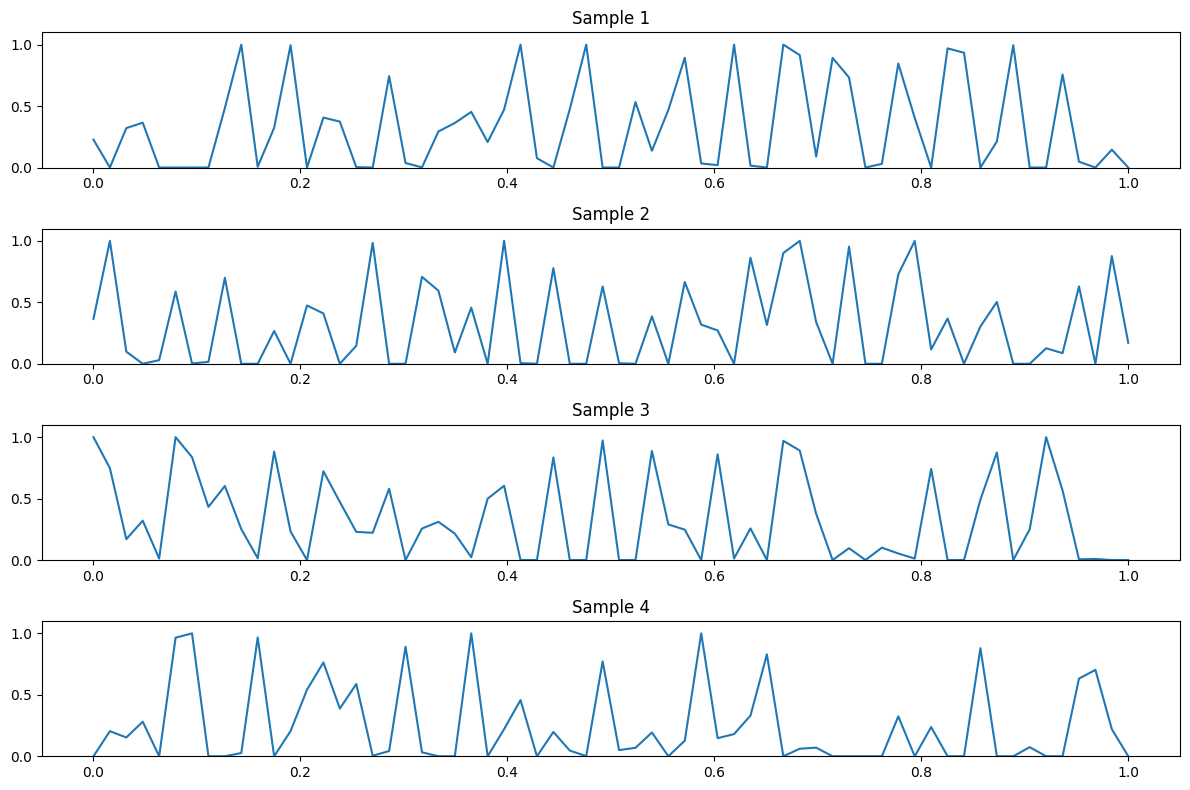

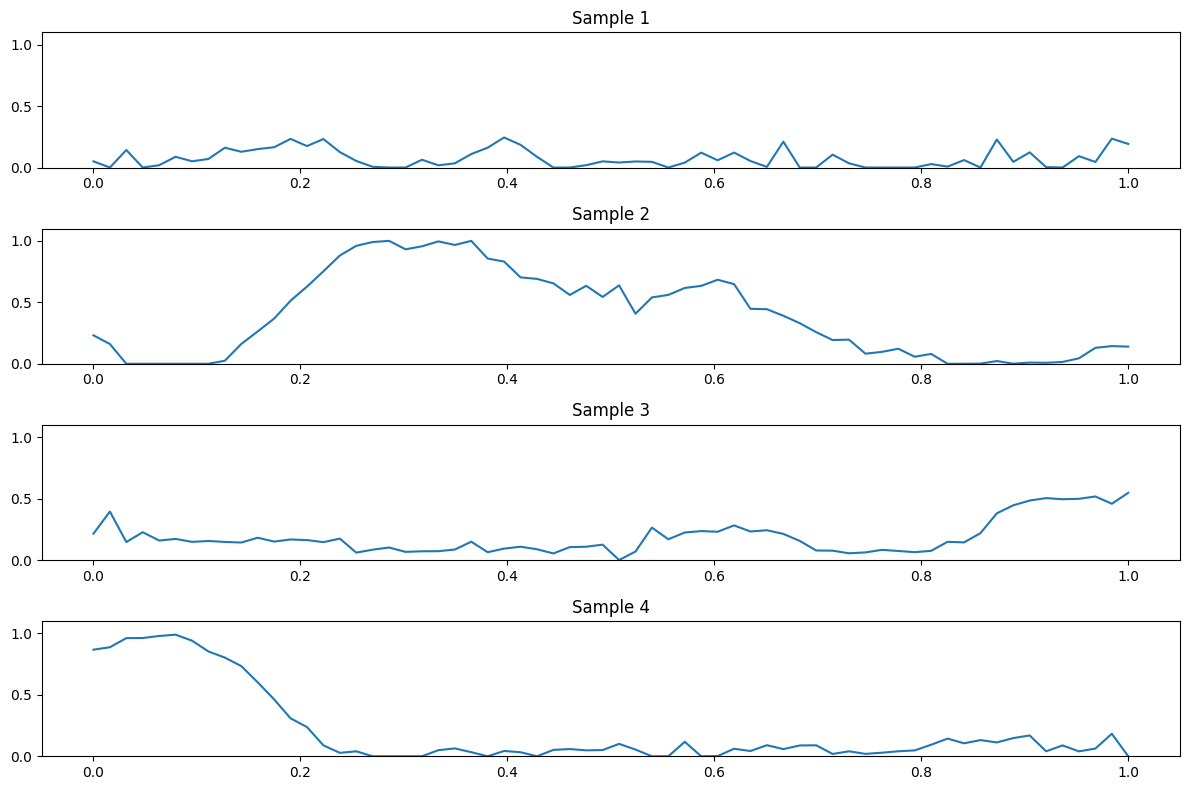

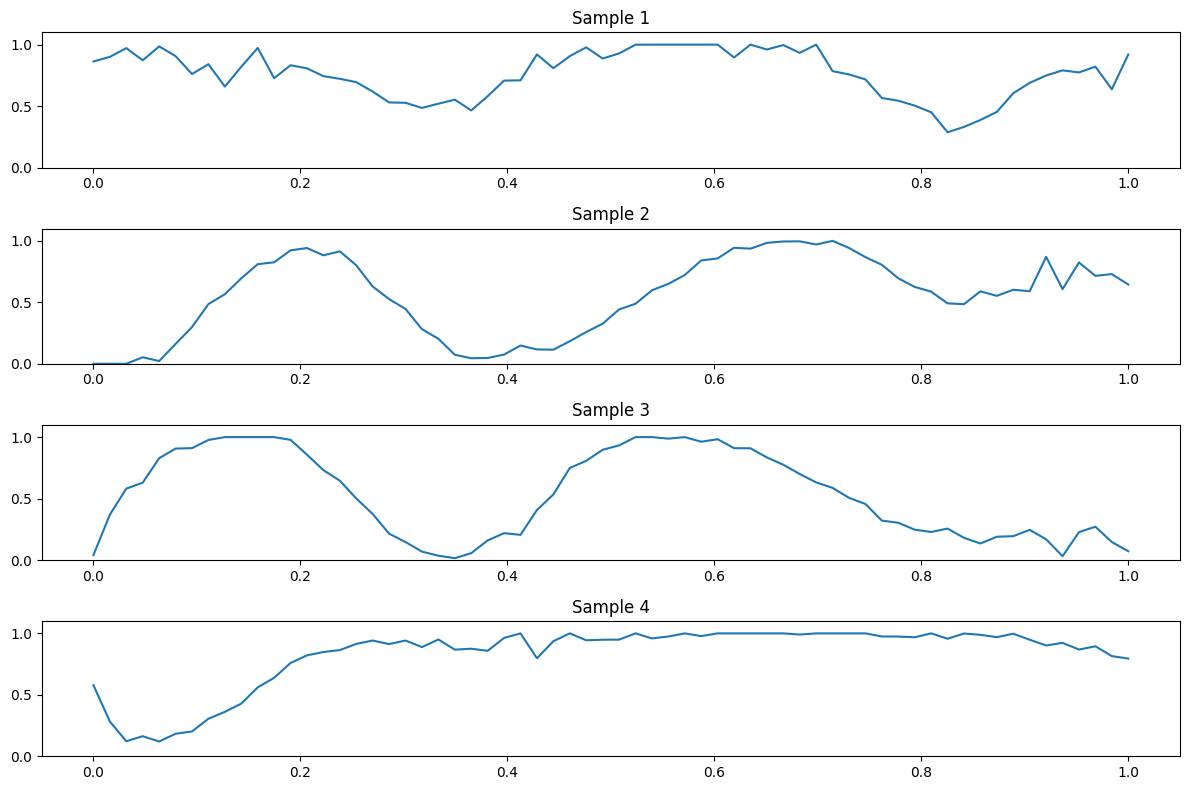

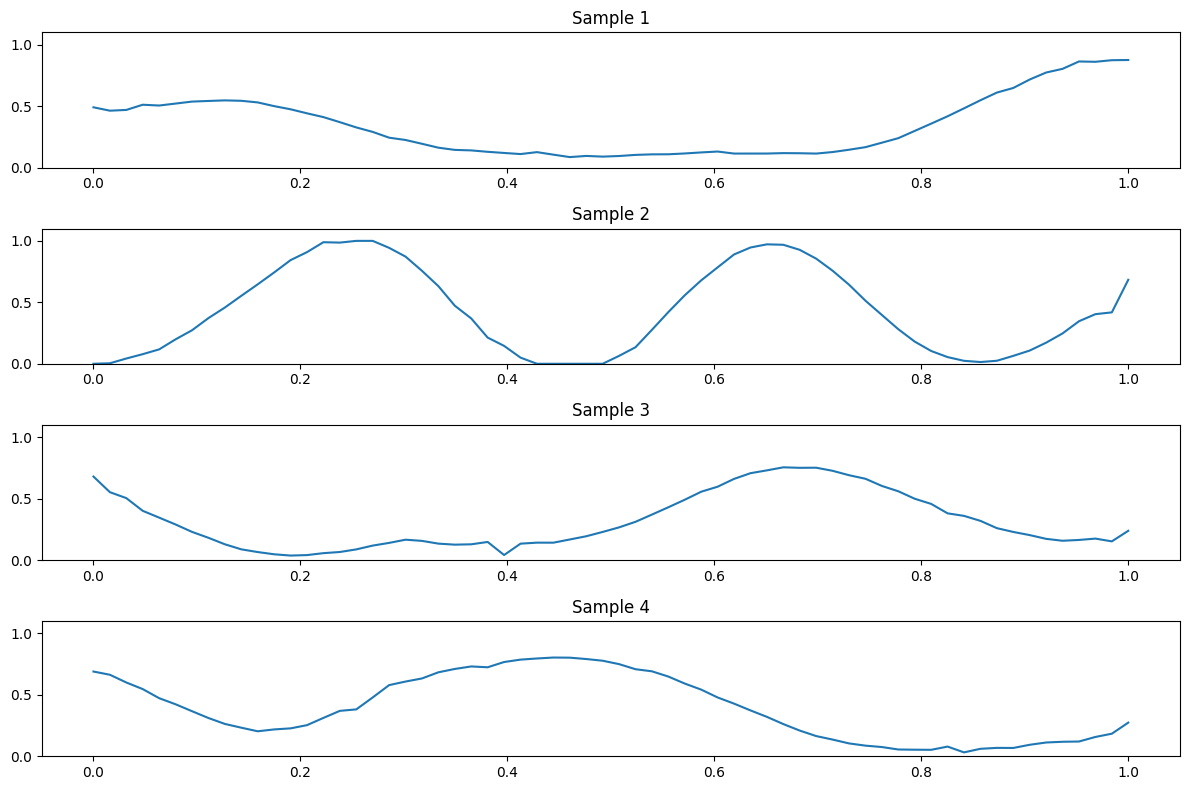

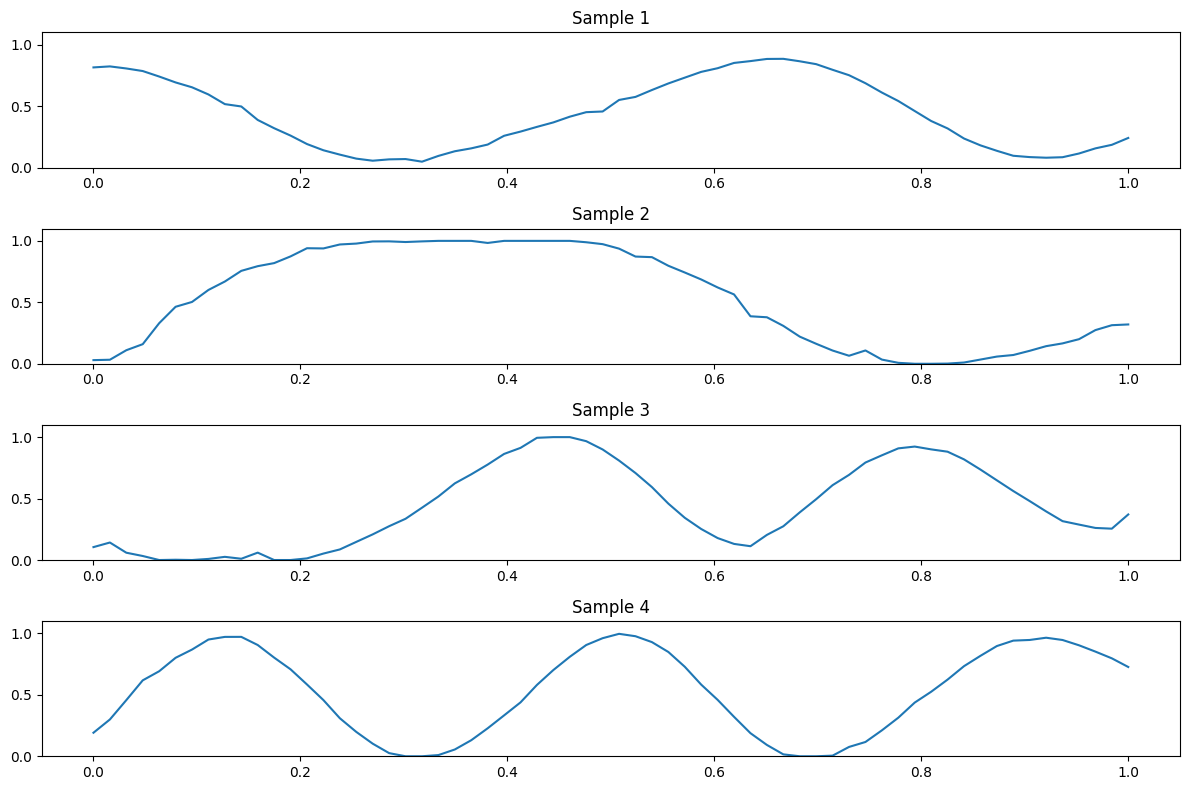

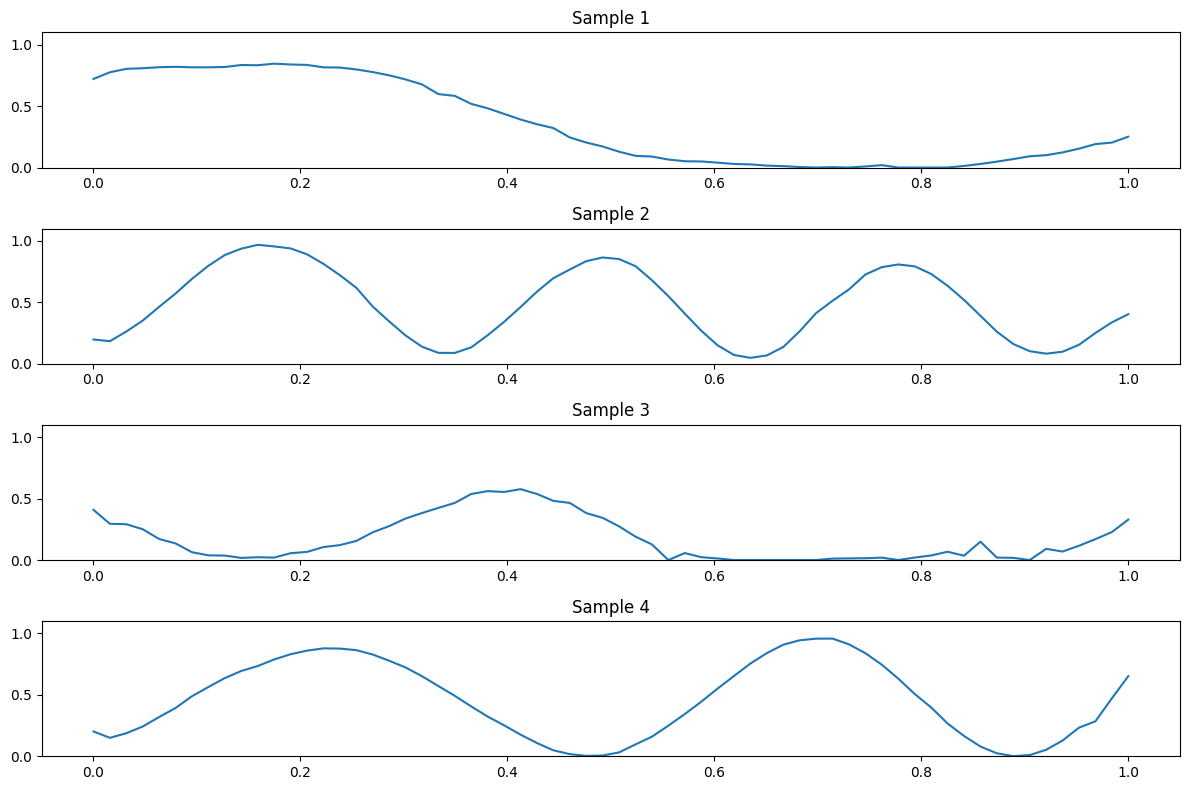

In [66]:
seq_length = 64
batch_size = 16
num_datapoints = 1000
epochs = 5

print(f"Using device: {device}")
dataset = SyntheticDataset(num_samples=num_datapoints, seq_length=seq_length)
model = Unet1D(
    dim=64,
    channels=1,
    dim_mults=(1, 2, 4)
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length=seq_length,
    timesteps=50,
    objective='pred_v'
)

initial_points = sample(diffusion)
train(diffusion, dataset, epochs=epochs)


In [170]:
    
def classifier_guidance_fn(x, t, classifier, guidance_scale=1.0):
    """
        Compute the gradient of the classifier score with respect to x
    """
    # Enable gradient computation for x
    x.requires_grad_(True)

    # Predict class score
    score = classifier(x)

    # Compute gradient
    grad = torch.autograd.grad(score.sum(), x)[0]

    # Scale the gradient
    return guidance_scale * grad

In [171]:
def sample_with_guidance(diffusion, classifier, guidance_scale=1.0, batch_size=4, seq_length=128, channels=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create a partial function for guidance
    def cond_fn(x, t):
        return classifier_guidance_fn(x, t, classifier, guidance_scale)
    
    # Sample with guidance
    samples = diffusion.sample(
        batch_size=batch_size,
        cond_fn=cond_fn,
        guidance_kwargs={}
    )
    
    # Also generate samples without guidance for comparison
    with torch.no_grad():
        samples_no_guidance = diffusion.sample(batch_size=batch_size)
    
    return samples, samples_no_guidance
sample_with_guidance(diffusion, classifier)

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn